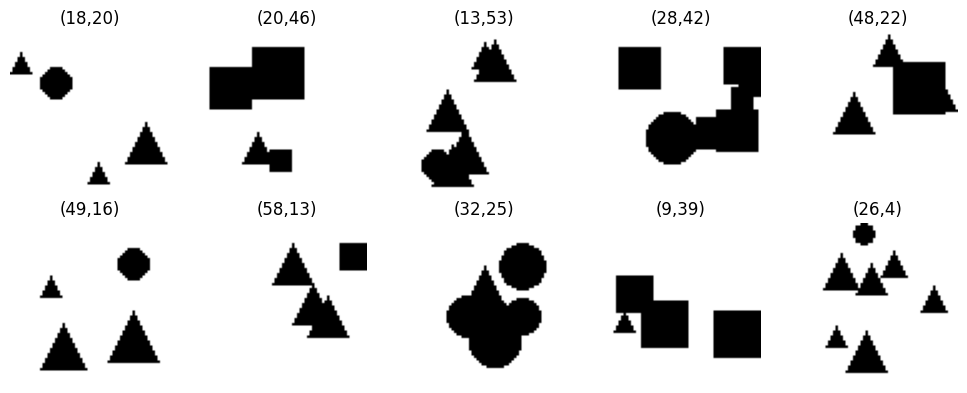

In [1]:
# ============================================================
# 0. Imports & device
# ============================================================
import torch, random, math, numpy as np
from torch import nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# ============================================================
# 1. Online dataset: 64×64, target = (cx,cy) ∈ [0,63]²  (float32)
# ============================================================
IMAGE = 64
SHAPES = ("circle", "square", "triangle")

def draw_shape(drawer, shape_type, center_x, center_y, radius):
    if shape_type == "circle":
        drawer.ellipse([center_x - radius, center_y - radius,
                        center_x + radius, center_y + radius], fill="black")
    elif shape_type == "square":
        drawer.rectangle([center_x - radius, center_y - radius,
                          center_x + radius, center_y + radius], fill="black")
    else:  # triangle
        drawer.polygon([
            (center_x, center_y - radius),
            (center_x - radius, center_y + radius),
            (center_x + radius, center_y + radius)
        ], fill="black")

class OddXYDataset(Dataset):
    """
    Generates images on-the-fly:
      * several random shapes of the same type
      * 1 additional shape of a different type
    Returns:
      * image (1×64×64 tensor, float32 normalized to [0,1])
      * label: float tensor [cx, cy] with center of the odd shape
    Arguments:
        num_samples             – total number of samples in the dataset
        same_shape_count_range – tuple (min, max), number of identical shapes
        shape_radius_range      – tuple (min_radius, max_radius) for shape size
    """
    def __init__(self,
                 num_samples,
                 same_shape_count_range=(3, 6),
                 shape_radius_range=(4, 10)):
        self.num_samples = num_samples
        self.same_shape_count_range = same_shape_count_range
        self.radius_min, self.radius_max = shape_radius_range

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        base_shape = random.choice(SHAPES)
        odd_shape = random.choice([s for s in SHAPES if s != base_shape])

        img = Image.new("L", (IMAGE, IMAGE), "white")
        drawer = ImageDraw.Draw(img)

        # draw identical shapes
        for _ in range(random.randint(*self.same_shape_count_range)):
            radius = random.randint(self.radius_min, self.radius_max)
            cx = random.randint(radius, IMAGE - radius - 1)
            cy = random.randint(radius, IMAGE - radius - 1)
            draw_shape(drawer, base_shape, cx, cy, radius)

        # draw the odd shape (with known center)
        radius = random.randint(self.radius_min, self.radius_max)
        cx = random.randint(radius, IMAGE - radius - 1)
        cy = random.randint(radius, IMAGE - radius - 1)
        draw_shape(drawer, odd_shape, cx, cy, radius)

        img_tensor = torch.tensor(np.array(img), dtype=torch.float32).unsqueeze(0) / 255.
        label_tensor = torch.tensor([float(cx), float(cy)], dtype=torch.float32)
        return img_tensor, label_tensor  # (1, 64, 64), (2,)

def show_examples(num_examples=10):
    """
    Displays a grid of image samples from OddXYDataset using a DataLoader with batch_size=1.

    Args:
        num_examples (int): Number of examples to display.
    """
    dataset = OddXYDataset(num_samples=num_examples)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

    num_columns = 5
    num_rows = math.ceil(num_examples / num_columns)

    fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns * 2, num_rows * 2))

    for i, (image, label) in enumerate(dataloader):
        if i >= num_examples:
            break
        image_np = image.squeeze(0).squeeze(0).numpy()  # B=1,C=1,H,W --> H,W
        cx, cy = label.squeeze(0)                       # B=1,2       --> 2
        axes.flat[i].imshow(image_np, cmap="gray")
        axes.flat[i].set_title(f"({cx:.0f},{cy:.0f})")
        axes.flat[i].axis("off")

    for j in range(i + 1, num_rows * num_columns):
        axes.flat[j].axis("off")

    plt.tight_layout()
    plt.show()



show_examples()

In [2]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import random, numpy as numpy, torch

samples_per_epoch  = 25_000
BATCH_SIZE= 256

def seed_worker(worker_id):                   # seeds dla każdego workera DataLoadera
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

g = torch.Generator()
g.manual_seed(0)

train_loader = DataLoader(
        OddXYDataset(samples_per_epoch),     # OddXYDataset
        batch_size=256,
        shuffle=True,
        num_workers=0,
        pin_memory=True,
        drop_last=True,
        worker_init_fn  = seed_worker,
        generator= g
)
# tensors w DataLoader:
# img: (BATCH_SIZE, 1, 64, 64) - 256x1x64x64
# target: (BATCH_SIZE, 2) - 256x2


In [3]:
!pip install vit-pytorch  #   vit-pytorch z repozytorium PyPI

import torch
from vit_pytorch import ViT

vit = ViT(
    image_size = 64,      # rozmiar wejściowego obrazu na 64x64 piksele
    patch_size = 4,       # Dzieli obraz na patche o rozmiarze 4x4 piksele (powstaje 16x16=256 patchy)
    channels= 1,          # Liczba kanałów wejściowych (1 – obrazy czarno-białe)
    num_classes = 0,
    dim   = 64,           # Wymiar przestrzeni embeddingów (każdy patch zamieniany na wektor 64-d)
    depth = 4,            # Liczba bloków transformera (głębokość modelu)
    heads = 8,            # Liczba głów atencji w każdym bloku transformera
    mlp_dim = 128         # Wymiar warstwy ukrytej w MLP (FeedForward) w każdym bloku transformera
)
# ViT input tensor
# x: (BATCH_SIZE, 1, 64, 64) - 256x1x64x64
# po patching, reshaping (BATCH_SIZE, num_patches, dim), gdzie num_patches = (64 // 4)^2 = 16*16 = 256
# x: (256, 256, 64) - 256 patches, każdy 64-dimensional

/usr/local/lib/python3.11/dist-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [4]:
import math
import torch


def positionalencoding1d(d_model, length):
    """
    :param d_model: dimension of the model
    :param length: length of positions
    :return: length*d_model position matrix
    """
    if d_model % 2 != 0:
        raise ValueError("Cannot use sin/cos positional encoding with "
                         "odd dim (got dim={:d})".format(d_model))
    pe = torch.zeros(length, d_model)  # (length, d_model) czyli (T, 64)
    position = torch.arange(0, length).unsqueeze(1)  # Tworzy tensor pozycji od 0 do length-1 i dodaje wymiar kolumny
    div_term = torch.exp((torch.arange(0, d_model, 2, dtype=torch.float) *
                         -(math.log(10000.0) / d_model)))  #(d_model/2)  Oblicza współczynniki dzielące dla każdej pary wymiarów
    pe[:, 0::2] = torch.sin(position.float() * div_term)  #(T, d_model) Wypełnia parzyste kolumny wartościami sinusów
    pe[:, 1::2] = torch.cos(position.float() * div_term)  #(T, d_model) Wypełnia nieparzyste kolumny wartościami cosinusów

    return pe  #(T, d_model) macierz pozycyjnych embeddingów


def positionalencoding2d(d_model, height, width):
    """
    :param d_model: dimension of the model
    :param height: height of the positions
    :param width: width of the positions
    :return: d_model*height*width position matrix
    """
    if d_model % 4 != 0:
        raise ValueError("Cannot use sin/cos positional encoding with "
                         "odd dimension (got dim={:d})".format(d_model))
    pe = torch.zeros(d_model, height, width)  #  tensor zerowy o wymiarach (d_model, height, width) czyli (64, 17, 17)
    d_model = int(d_model / 2)  # Dzieli wymiar embeddingu na pół (połowa na wysokość, połowa na szerokość)
    div_term = torch.exp(torch.arange(0., d_model, 2) *
                         -(math.log(10000.0) / d_model))  # (d_model / 2) współczynniki dzielące dla każdej pary wymiarów
    pos_w = torch.arange(0., width).unsqueeze(1)   # (17, 1) tensor pozycji szerokości i dodaje wymiar kolumny
    pos_h = torch.arange(0., height).unsqueeze(1)  #  (17, 1) tensor pozycji wysokości i dodaje wymiar kolumny
    pe[0:d_model:2, :, :] = torch.sin(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
    pe[1:d_model:2, :, :] = torch.cos(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
    pe[d_model::2, :, :] = torch.sin(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
    pe[d_model + 1::2, :, :] = torch.cos(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)

    return pe  # (d_model, height, width) czyli (64, 17, 17)tensor pozycyjnych embeddingów 2D

In [5]:
class MLP(nn.Module):
    def __init__(self, in_dim, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 4*in_dim),   # (batch, in_dim) czyli (B, 64) potem (B, 256) Warstwa liniowa
            nn.GELU(),                     # Funkcja aktywacji GELU (nieliniowość)
            nn.Dropout(dropout),           # Warstwa dropout dla regularizacji
            nn.Linear(4*in_dim, in_dim),   # (B, 256) potem (B, 64) Warstwa liniowa: zmniejsza wymiar z powrotem do in_dim
            nn.Dropout(dropout)            # Kolejna warstwa dropout
        )
    def forward(self, x):
        return self.net(x)           # input oraz outpit: (B,T,F) Przepuszcza dane wejściowe przez sieć MLP

class TransformerBlock(nn.Module):
    def __init__(self, dim, heads=4, dropout=0.1):
        super().__init__()  #  konstruktor klasy bazowej nn.Module
        self.attn  = nn.MultiheadAttention(dim, heads, dropout=dropout,
                                           batch_first=True)  # (B, T, F) MultiheadAttention
        self.norm1 = nn.LayerNorm(dim)      #(B, T, F) Normalizacja warstwy po atencji
        self.mlp   = MLP(dim, dropout)      # (B, T, F) (zostaje) Blok MLP jako feed-forward
        self.norm2 = nn.LayerNorm(dim)      # (B, T, F) normalizacja warstwy po MLP

    def forward(self, x): # x: (B,T,F)
        x = x + self.attn(x, x, x)[0]   #(B, T, F) residual connection
        x = self.norm1(x)               #(B, T, F) Normalizuje wynik po atencji
        x = x + self.mlp(x)             #(B, T, F) Dodaje wynik MLP do wejścia - residual connection
        x = self.norm2(x)               #(B, T, F) Normalizuje wynik po MLP
        return x                     # (B,T,F)
#  CNN: (BATCH_SIZE, embed_cnt, H, W) czyli (256, 32, 17, 17) dla H=W=17 po convolution
# po Flattening: (BATCH_SIZE, T, F) czyli (256, 289, 32), gdzie T=17*17=289 patches, F=32 embedding dim


In [6]:
def conv_centers(kernel, stride, h, w, device):
    iy, ix = torch.meshgrid(torch.arange(h), torch.arange(w), indexing='ij')  #(17, 17) siatka indeksów dla wysokości (iy) i szerokości (ix)
    # 64×64
    cx = ix * stride + kernel // 2      # (17, 17) współrzędne x środków pól recepcyjnych (przesuwa każdy indeks o połowę rozmiaru kernela)
    cy = iy * stride + kernel // 2      # (17, 17) współrzędne y środków pól recepcyjnych (przesuwa każdy indeks o połowę rozmiaru kernela)
    centers = torch.stack([cx, cy], -1).view(-1, 2).float()   #  współrzędne x i y w jeden tensor o kształcie (T,2) czyli (289, 2) i konwertuje na float
    return centers.to(device)           # (289, 2) CPU lub GPU

In [7]:
import numpy as np
# kod z lab13 (zmodyfikowany)

import torch.nn.functional as F

feature_cnt =embed_cnt = 32          # word embeddings

H = W = 17 #po konwolucji (kernel = 20, stride = 4) obraz 64 × 64 zamienia się w mapę 12 × 12
T = H * W

class SelfAttention(nn.Module):
  """
    Self-Attention mechanism.
  """
  def __init__(self, emb_dim, kqv_dim, num_heads=1):
    super(SelfAttention, self).__init__()
    self.emb_dim = emb_dim  #  wymiar wejściowy embeddingów
    self.kqv_dim = kqv_dim  #  wymiar kluczy/zapytań/wartości
    self.num_heads = num_heads  # liczba głów atencji

    self.w_k = nn.Linear(emb_dim, kqv_dim*num_heads, bias=False)  # warstwa liniowa do generowania kluczy
    self.w_q = nn.Linear(emb_dim, kqv_dim*num_heads, bias=False)  # warstwa liniowa do generowania zapytań
    self.w_v = nn.Linear(emb_dim, kqv_dim*num_heads, bias=False)  # warstwa liniowa do generowania wartości
    self.w_out = nn.Linear(kqv_dim * num_heads, emb_dim)          # warstwa wyjściowa do połączenia głów

  def get_mask(self):
    pass

  def forward(self, inputs, attention_mask=None):
    b, t, _ = inputs.shape  #  rozmiary: batch, liczba tokenów, wymiar
    e = self.kqv_dim        # wymiar kluczy/zapytań/wartości
    h = self.num_heads      # liczba głów

    if attention_mask is not None:
      attention_mask = attention_mask.unsqueeze(-1)  # dodaj wymiar do maski
      inputs = inputs * attention_mask               # zamaskuj wejście

    keys = self.w_k(inputs).view(b, t, h, e)         #  klucze i przekształć do (batch, tokeny, głowy, wymiar)
    values = self.w_v(inputs).view(b, t, h, e)       #  wartości i przekształć
    queries = self.w_q(inputs).view(b, t, h ,e)      #  zapytania i przekształć

    keys = keys.transpose(1, 2).contiguous().view(b*h, t, e)      # przestaw wymiary i spłaszcz batch oraz headss
    queries = queries.transpose(1, 2).contiguous().view(b*h, t, e)
    values = values.transpose(1, 2).contiguous().view(b*h, t, e)

    attn_scores = torch.bmm(queries, keys.transpose(1, 2))         # oblicz produkty skalarne zapytań i kluczy
    attn_scores = attn_scores / np.sqrt(e)                         # normalizacja

    if attention_mask is not None:
      attn_scores = attn_scores * attention_mask                   # zamaskuj wyniki atencji
    attn_scores = F.softmax(attn_scores, dim=2)                    # softmax po tokenach czyli normalizacja wag
    weighted_values = torch.bmm(attn_scores, values).view(b, h, t, e) #  wagi do wartości i przekształć
    weighted_values = weighted_values.transpose(1, 2).contiguous().view(b, t, h*e) # przestaw i spłaszcz heads
    if attention_mask is not None:
      weighted_values = weighted_values * attention_mask
    outputs = self.w_out(weighted_values)

    return outputs



class Net_Attention_And_PE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Conv2d(1, embed_cnt, kernel_size=16, stride=3)  # (1, 64, 64) przechodzi na (32, 17, 17) warstwa konwolucyjna: 1 kanał wejściowy, embed_cnt wyjściowych
        self.encoder = nn.Sequential( TransformerBlock(feature_cnt, 4, 0.1), TransformerBlock(feature_cnt, 4, 0.1) )
        self.pe = nn.Parameter(torch.randn(1, T, feature_cnt, device=device))  # (1, 289, 32) pozycjonalne embeddingi
        self.head_cls = nn.Linear(32, 1)      # (B, 32) przechodzi na(B, 1)  głowa klasyfikacyjna (do wyznaczania prawdopodobieństw)
        self.head_off = nn.Linear(32, 2)      #  (B, 32) przechodzi na (B, 2)głowa regresyjna (do wyznaczania przesunięcia)
        centers = conv_centers(kernel=16, stride=3, h=17, w=17,
                               device=torch.device('cpu'))        # oblicz centra pól (289, 2)
        self.register_buffer('centers', centers, persistent=False)  # (289, 2) zapisz

    def forward(self, img):
        x = self.cnn(img)                       # (B, 1, 64, 64)  przechodzi na (B, 32, 17, 17) przetwórz obraz przez CNN
        x = x.flatten(2).transpose(1,2)              # (B, 32, 17, 17) przechodzi na (B, 289, 32) spłaszcz i zamień wymiary na (batch, tokeny, cechy)
        x = x + self.pe                              #  (B, 289, 32) i (1, 289, 32)  przechodzi na  (B, 289, 32) dodaj pozycjonalne embeddingi
        x = self.encoder(x)        #(B, 289, 32) przetwórz przez transformer
        #x = x.mean(1)
        #x = self.attention(x).squeeze(1)                   # (B,16)
        #coord = self.out_xy(x)                       # (B,2)
        #return coord
        p = self.head_cls(x).softmax(1)              #(B, 289, 1) przechodzi na (B, 289, 1)  prawdopodobieństwa dla każdego tokena
        coarse = (p * self.centers).sum(1)           # (B, 289, 2) przechodzi na (B, 2) współrzędne jako ważoną sumę centrów
        offset = (p * self.head_off(x)).sum(1)       # (B, 289, 2) przechodzi na (B, 2) przesunięcie jako ważoną sumę przesunięć

        return coarse + offset                       #  końcowe współrzędne (B,2)


net_att_pe = Net_Attention_And_PE()
# output :coarse + offset: (BATCH_SIZE, 2) - 256x2 ( wspórzędne dla batch)

In [8]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler
from torch.amp import autocast, GradScaler

try:         # torch.amp
    from torch.amp import autocast, GradScaler
except ImportError:                 # torch.cuda.amp
    from torch.cuda.amp import autocast, GradScaler

use_cuda = torch.cuda.is_available()           #  czy dostępne jest CUDA (GPU)
scaler   = GradScaler(enabled=use_cuda)          # GradScaler z AMP, aktywowanego jeśli używany jest GPU
device   = torch.device('cuda' if use_cuda else 'cpu')  # 'cuda' lub 'cpu' w zależności od dostępności GPU
model= Net_Attention_And_PE().to(device)         # Inicjalizacja Net_Attention_And_PE

optimizer = torch.optim.RMSprop(model.parameters(), lr=0.00001,
                              alpha=0.99, eps=1e-08, weight_decay=0.0001, momentum=0.0001, centered=False) #  optymalizator RMSprop z zadanymi parametrami dla wag modelu
n_epochs = 100                                   # epoki
scheduler_1cycle = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=5e-4,
    epochs=n_epochs,
    steps_per_epoch=len(train_loader))
                                                 # Inicjalizacja OneCycleLR dla optymalizatora określonego maksymalnego lr, liczby epok i kroków na epokę


def train_epoch(model, optimizer, loader, loss_history):
    model.train()                              # train mode
    total_rmse, total_samples = 0.0, 0
    #total = len(loader.dataset)               # Obliczenie liczby próbek w zbiorze danych

    for i, (img, target) in enumerate(loader):  # Iteracja po partiach danych z loadera, pobierając obrazy i etykiety
        img, target = img.to(device), target.to(device)  # przeniesienie na wybrane GPU/CPU

        optimizer.zero_grad()                    # zerowanie gradientów optymalizatora
       # pred  = model(img)  #  Obliczenie predykcji przez model
       # loss  = F.mse_loss(pred, target)   # Obliczenie straty MSE między predykcjami a etykietami
        with autocast(device_type='cuda'):   #  automatyczna mieszana precyzja dla przyspieszenia obliczeń na GPU
            preds = model(img)                   #   (B, 2) predykcja przez model przy użyciu AMP
            loss  = F.mse_loss(preds, target)     # scalar straty MSE pomiędzy predykcjami a prawdziwymi etykietami

        scaler.scale(loss).backward()  # Skalowanie straty i wykonanie propagacji wstecznej przy użyciu AMP
        scaler.step(optimizer)                   # Aktualizacja parametrów modelu przez optymalizator
        scheduler_1cycle.step()                # Aktualizacja harmonogramu szybkości uczenia lr
        scaler.update()                          # Aktualizacja AMP
        batch_rmse= loss.sqrt().item()
        total_rmse+= batch_rmse * img.size(0)      # sumaryczny RMSE, mnożąc RMSE przez liczbę próbek
        total_samples+= img.size(0)              # Akumulacja liczby przetworzonych próbek

        if i % 100 == 0:
            print(f'[{i*len(img):5}/{len(loader.dataset):5} '
                  f'({100*i/len(loader):3.0f}%)]  RMSE: {batch_rmse:6.4f}')

            loss_history.append(batch_rmse)      # Dodanie RMSE do listy

    return total_rmse / total_samples           # Zwrócenie średniego RMSE dla całej epoki

# Learning rate scheduler
#scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

hist = []                              # historia RMSE dla kolejnych epok
for ep in range(1, n_epochs + 1):
    epoch_rmse  = train_epoch(model, optimizer, train_loader, hist)
#    scheduler.step(epoch_rmse )          # Aktualizacja harmonogramu redukującego lr według wartości RMSE
    print(f"Epoka {ep:02d}  RMSE = {epoch_rmse :.3f}")  # numer epoki i RMSE


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


[    0/25000 (  0%)]  RMSE: 14.4847
Epoka 01  RMSE = 13.442
[    0/25000 (  0%)]  RMSE: 13.5373
Epoka 02  RMSE = 13.374
[    0/25000 (  0%)]  RMSE: 13.7961
Epoka 03  RMSE = 13.318
[    0/25000 (  0%)]  RMSE: 13.4970
Epoka 04  RMSE = 13.269
[    0/25000 (  0%)]  RMSE: 12.7153
Epoka 05  RMSE = 12.974
[    0/25000 (  0%)]  RMSE: 12.8970
Epoka 06  RMSE = 12.455
[    0/25000 (  0%)]  RMSE: 11.7551
Epoka 07  RMSE = 11.750
[    0/25000 (  0%)]  RMSE: 11.4411
Epoka 08  RMSE = 10.431
[    0/25000 (  0%)]  RMSE: 10.6395
Epoka 09  RMSE = 9.728
[    0/25000 (  0%)]  RMSE: 9.5744
Epoka 10  RMSE = 9.249
[    0/25000 (  0%)]  RMSE: 9.1567
Epoka 11  RMSE = 8.676
[    0/25000 (  0%)]  RMSE: 8.1268
Epoka 12  RMSE = 7.596
[    0/25000 (  0%)]  RMSE: 6.7921
Epoka 13  RMSE = 6.909
[    0/25000 (  0%)]  RMSE: 6.2798
Epoka 14  RMSE = 6.258
[    0/25000 (  0%)]  RMSE: 6.9371
Epoka 15  RMSE = 5.956
[    0/25000 (  0%)]  RMSE: 5.4093
Epoka 16  RMSE = 5.725
[    0/25000 (  0%)]  RMSE: 4.2982
Epoka 17  RMSE = 5.6

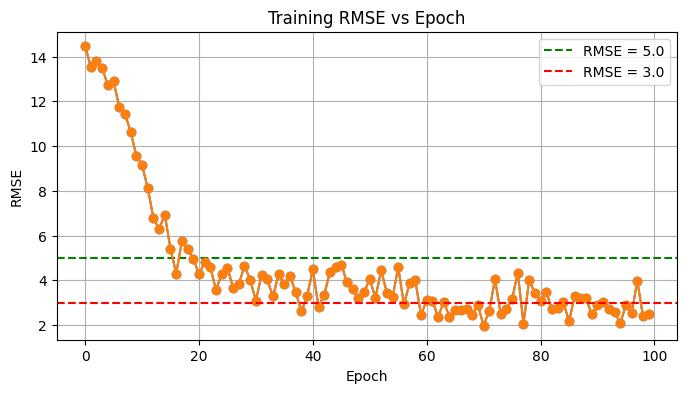

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(hist, marker='o')
plt.axhline(5.0, color='green', linestyle='--', label='RMSE = 5.0')
plt.plot(hist, marker='o')
plt.axhline(3.0, color='red', linestyle='--', label='RMSE = 3.0')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Training RMSE vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

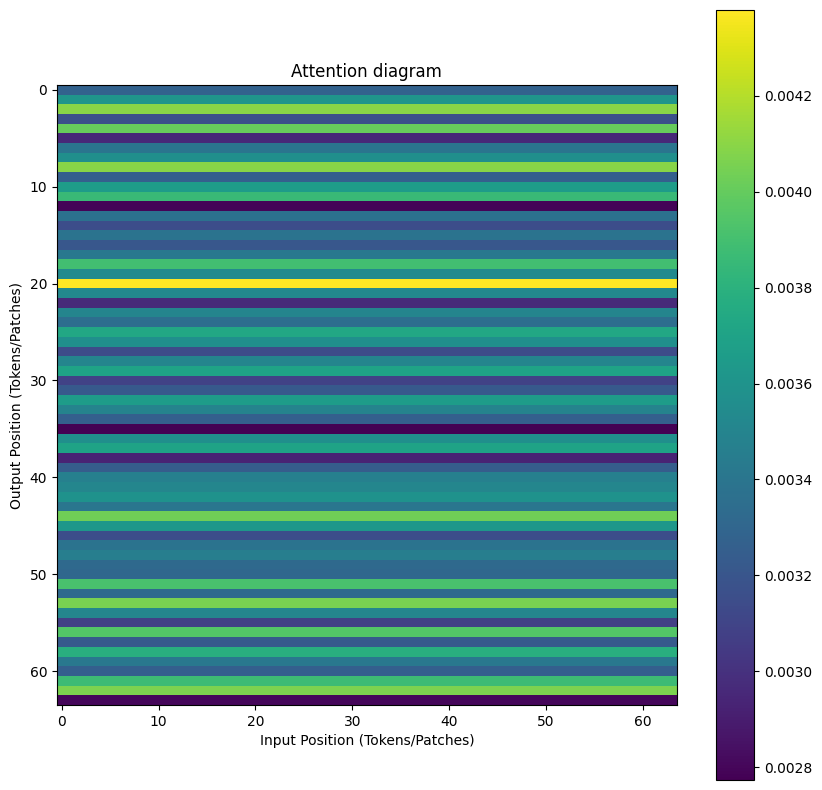

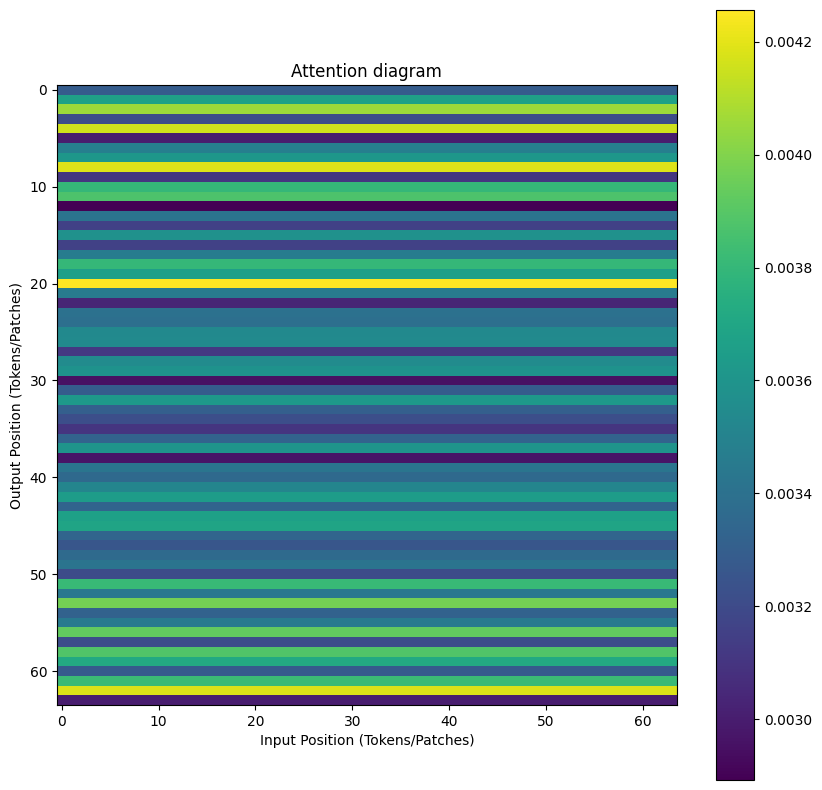

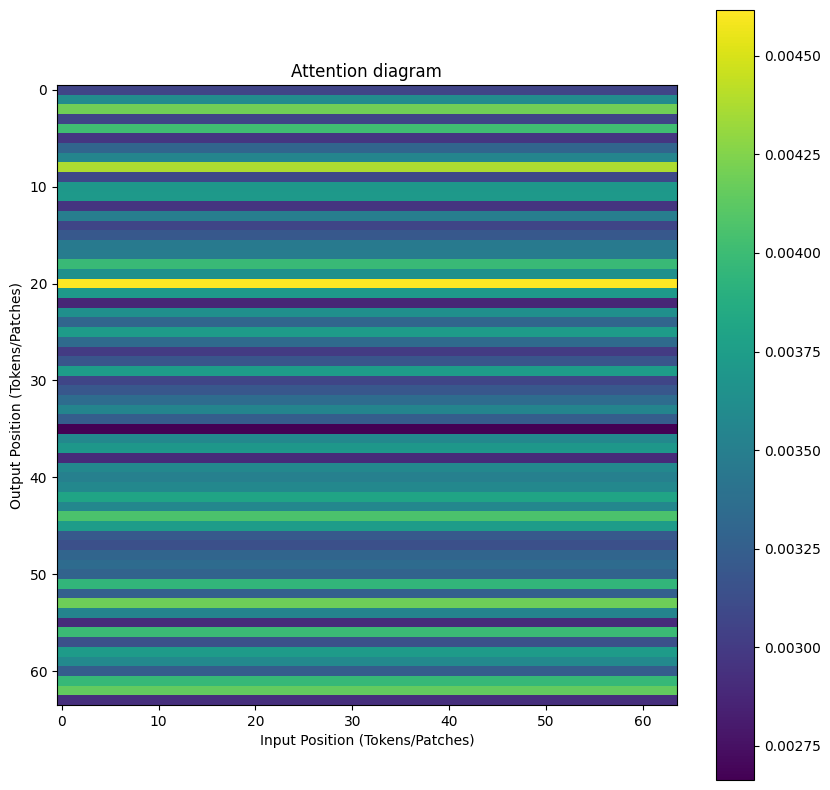

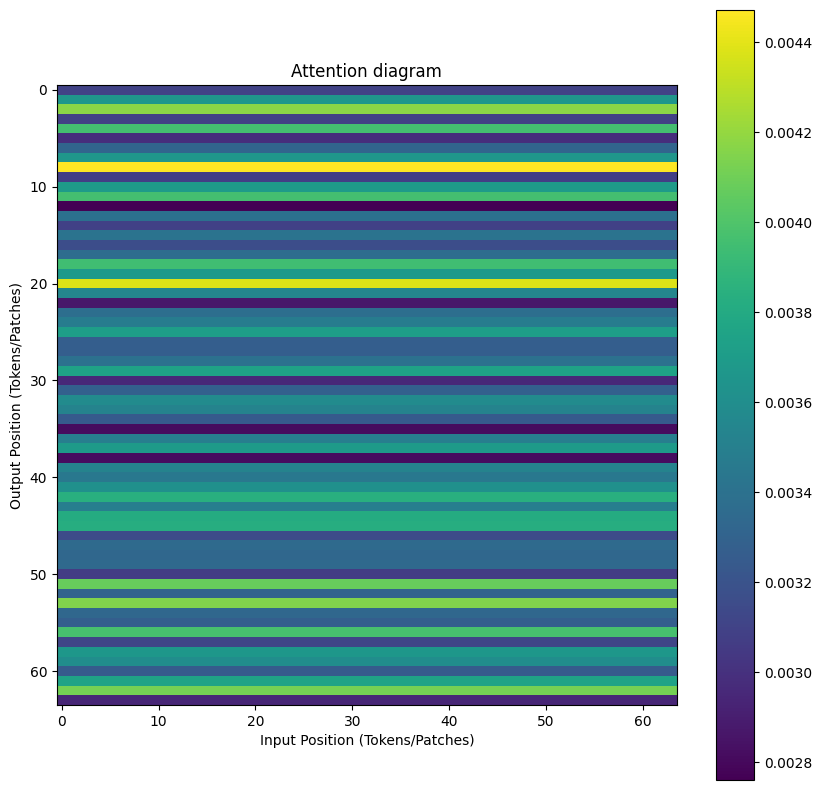

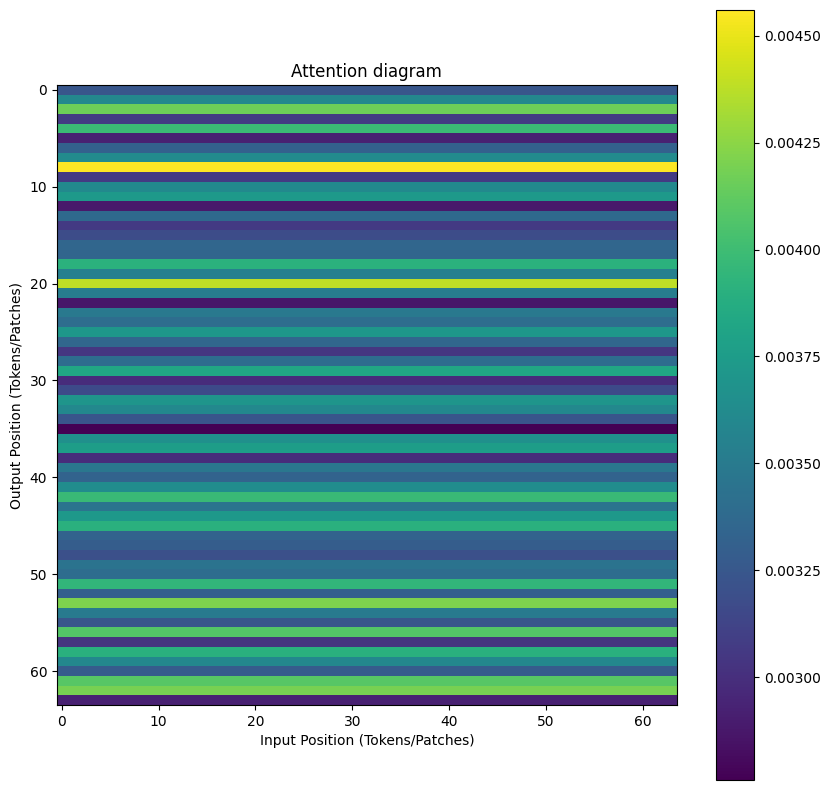

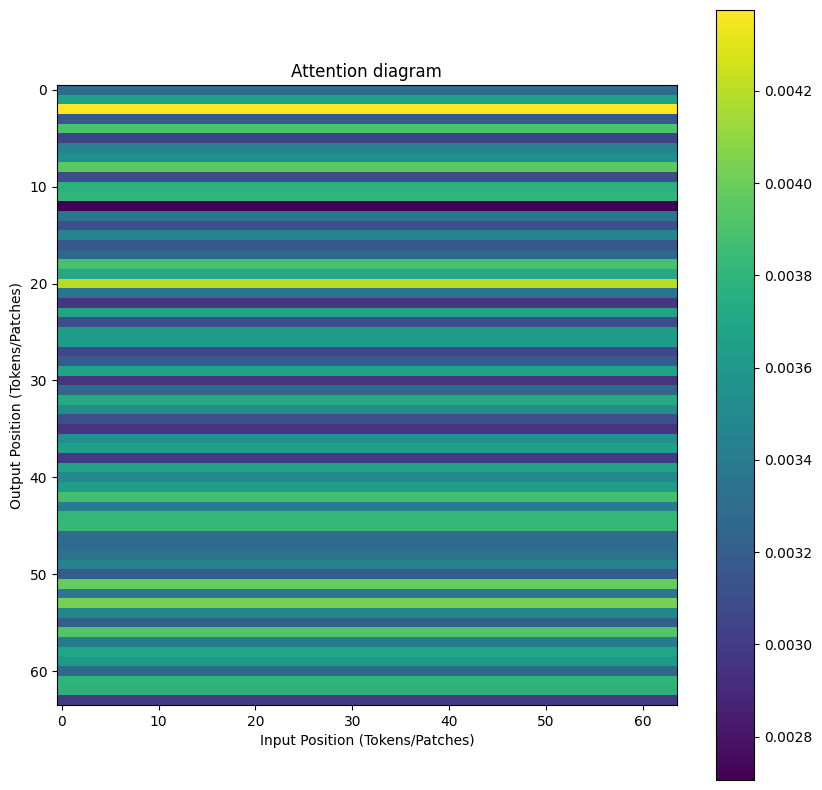

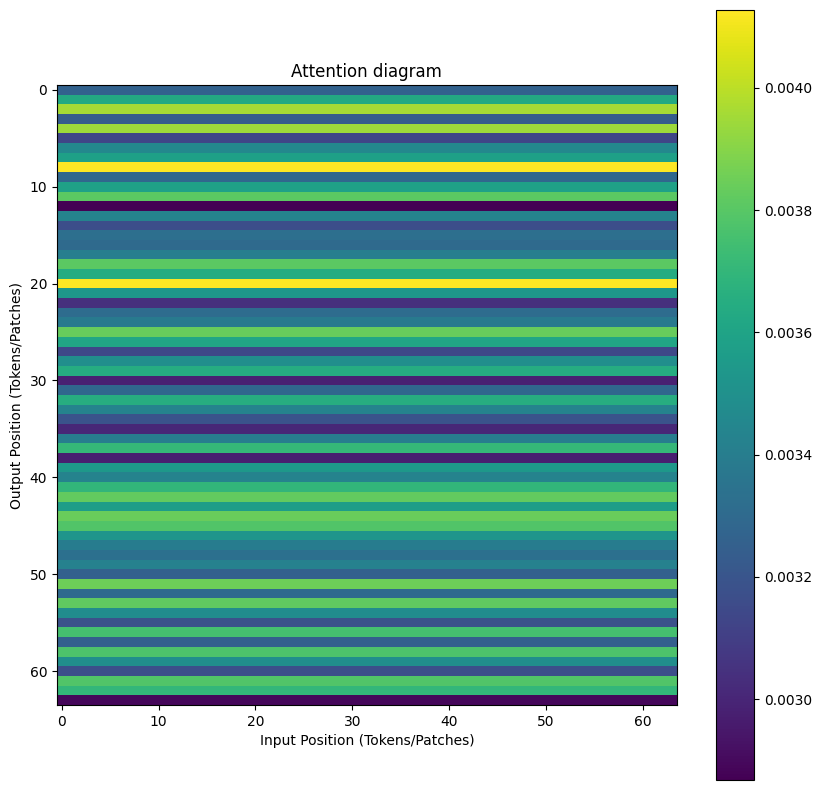

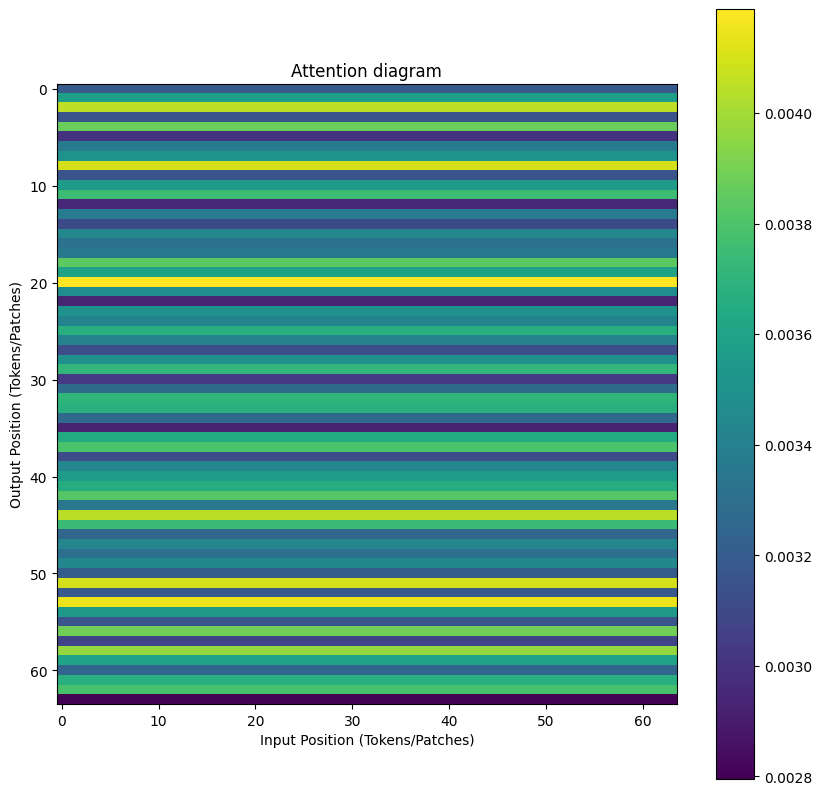

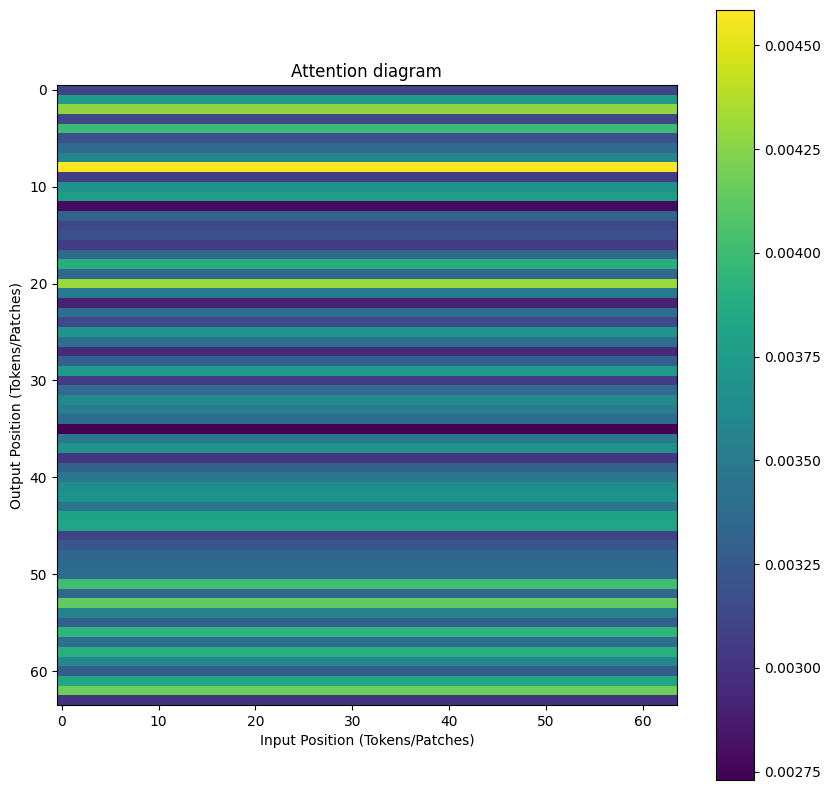

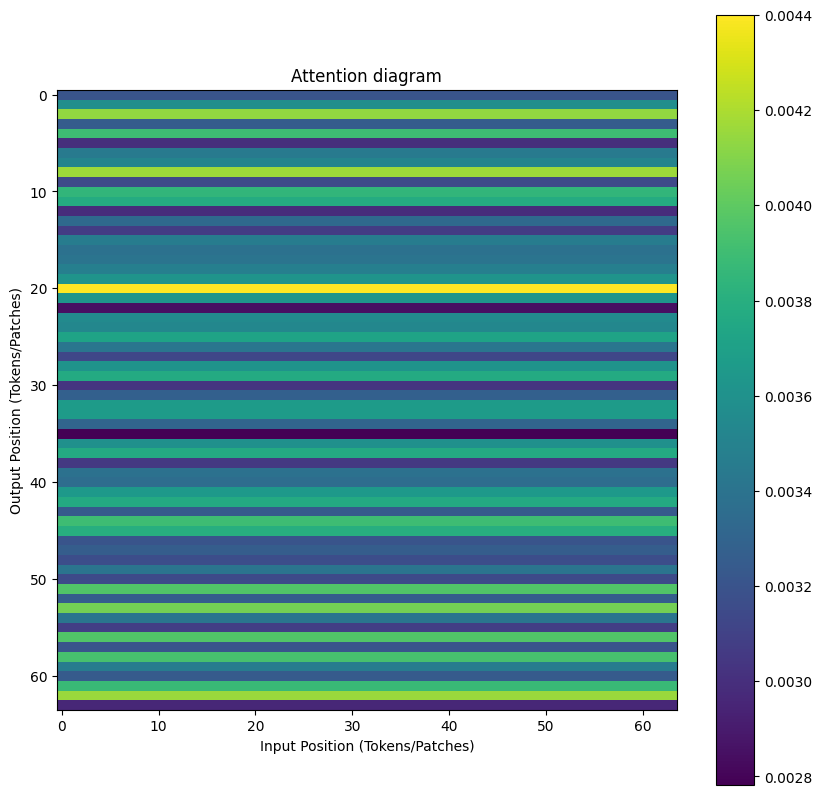

In [10]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
attention_hooks = []

def get_attention_hook(module, input, output):
    attention_scores = output[1].detach().cpu().numpy()  # output[1] wagi attention(po softmax)
    attention_hooks.append(attention_scores)

def visualize_attention_for_shapes(img, model):
    model.to(device)

    #  hook w SelfAttention
    for layer in model.encoder:
        layer.attn.register_forward_hook(get_attention_hook)

    model.eval()
    img = img.unsqueeze(0).to(device) # (1, 1, 64, 64)

    with torch.no_grad():
        _ = model(img)

    # ostatnia mapa attention
    if attention_hooks:
        attention_map = attention_hooks[-1] # (num_heads, T, T)

        attention_map = np.mean(attention_map, axis=1)  # (num_heads, T) średnia dla głów

        attention_map = attention_map[0] # (T,)
        attention_map = cv2.resize(attention_map, (img.shape[2], img.shape[3]))

        # visualization
        plt.figure(figsize=(10, 10))
        plt.imshow(attention_map, cmap='viridis', interpolation='nearest')
        plt.title("Attention diagram")
        plt.xlabel("Input Position (Tokens/Patches)")
        plt.ylabel("Output Position (Tokens/Patches)")
        plt.colorbar()
        plt.show()


    for layer in model.encoder:
        layer.attn._forward_hooks.clear()


dataset = OddXYDataset(num_samples=10)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)

for img, label in data_loader:
    img = img.squeeze(0)
    visualize_attention_for_shapes(img, net_att_pe)




###Embedding:

Aby przetworzyć obraz, używamy sieci CNN (nn.Conv2d), która konwertuje obraz na mapę cech o wymiarach 12×12 z 16 kanałami (gdzie każde pole receptywne reprezentowane jest przez 16-wymiarowy wektor). Mapa cech ma 144 różne pola, ponieważ obrazek 64×64 podzielony jest na 12×12 pól (z rozmiarem receptywnego pola 20×20 pikseli i krokiem 4x4).
Każde z tych 144 pól jest traktowane jako token, który zostaje przetworzony na wektor cech o wymiarze 16. Wynik jest spłaszczany i transponowany przed transformatorami.


###Positional Encoding (positionalencoding2d):

 Aby model mógł uwzględnić położenie każdego tokena w przestrzeni obrazu, dodajemy Positional Encoding. Stosujemy Positional Encoding oparty na sinusach, co pozwala zachowywać relacje przestrzenne (niezależność od wymiarów obrazu). Każdy Positional Encoding  jest wektorem o długości 16, one odpowiadają wymiarowi wektorów cech obrazu (są dodawane do wektorów cech obrazu).
Pozycje kodowane są na podstawie indeksów tokenów od 0 do 143.
Czyli mamy:


$$
\begin{gathered}
P E_{(p o s, 2 i)}=\sin \left(\frac{p o s}{10000^{2 i / d}}\right) \\
P E_{(p o s, 2 i+1)}=\cos \left(\frac{p o s}{10000^{2 i / d}}\right)
\end{gathered}
$$
gdzie:

$pos$ to pozycja tokena,


$i$ to indeks wymiaru wektora w embeddingu,


$d$ to wymiar embeddingu (w tym przypadku 16).



###Attention (nn.MultiheadAttention + TransformerBlock ):

 Stosujemy self-attention, który uwzględnia interakcję pomiędzy tokenami (reprezentującymi fragmenty obrazu), co pozwala lepiej zrozumieć wzorce na obrazie. W tym przypadku mamy multi-head attention, która pozwala modelowi równocześnie analizować różne aspekty obrazu.
 Self-attention dla każdego tokenu oblicza się zapytanie (query), klucz (key) i wartość (value), potem  porównuje zapytania i klucze dla każdej pary tokenów i w taki sposób określa wagę, którą model przypisuje danej parze. Natomiast multi-head attention zamiast jednej pary zapytań, kluczy i wartości, dzieli wektory na kilka mniejszych, i każda z tych głów oblicza self-attention oddzielnie, na końcu wyniki z różnych głów są łączone (czyli na przykład każda “głowa” analizuje różne właściwości danych wejściowych (kształt, teksturę, pozycję i tp) i w taki sposób rozpoznaje bardziej złożone wzorce)
Czyli mamy:
$$
\operatorname{Attention}(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^T}{\sqrt{d_k}}\right) V
$$

gdzie:

$Q$, $K$, $V$ to macierze zapytań (Query), kluczy (Key) i wartości (Value),


$d_k$ - wymiar klucza.



###Post-Processing:

Wyniki multi-head attention przechodzą do  MLP (czyli MLP działa jako część transformera), który działa na każdym tokenie osobno (ale MLP działa na wszystkich tokenach w każdej iteracji), MLP przetwarza poprzez dwie warstwy liniowe z funkcjami aktywacji oraz dropout (losowe wyłączanie pewnej liczby neuronów w trakcie treningu) aby zwiększyć nieliniowość i zapobiegać przeuczeniu.
Wynik MLP jest dodawany z powrotem do danych, które zostały przekazane do MLP (przy użyciu residual connection) i normalizowany przez drugą warstwę normalizacji.
Rezultatem jest logit (są wynikiem klasyfikatora, który działa na wynikach z MLP) dla każdego z 144 tokenów, który następnie jest przetwarzany na rozkład prawdopodobieństwa (softmax). Czyli otrzymujemy prawdopodobieństwo, że "dziwna" figura znajduje się w danym miejscu na obrazie.
softmax:
$$
p_i=\frac{e^{\text {logit }_i}}{\sum_{j=1}^{144} e^{\text {logit }_j}}
$$
gdzie $p_i$ to prawdopodobieństwo, że "dziwna" figura znajduje się w danym miejscu $i$ na obrazie.

Czyli ważona suma pozycji daje współrzędne.


###Offset Regressor (head_off):

 Nie mamy na razie mechanizmu, który pomaga w przypadkach, gdy figura znajduje się w rogu lub na granicy pól. Dlatego dodajemy regresor offsetu, który poprawia dokładność predykcji, bo oblicza lokalne przesunięcia w obrębie pola receptywnego.
lokalne przesunięcie $(\Delta x, \Delta y)$ dla każdej pozycji obliczamy w następujący sposób:
$$
(\Delta x, \Delta y)_i=f_{\text {offset }}\left(x_i, y_i\right)
$$

gdzie $f_{\text{offset}}$ to funkcja przewidująca lokalne przesunięcia.

Te przesunięcia są ważone przez prawdopodobieństwa, które zostały obliczone wcześniej (poprzez softmax):
$$
\sum_{i=1}^T p_i \cdot(\Delta x, \Delta y)_i
$$


Czyli mamy: ważoną sumę środków coarse i przesunięć offset.

Końcowa predykcja jest sumą :
$$
\text { final prediction }=\underbrace{\sum_i p_i \cdot C_i}_{\text {soft argmax }}+\underbrace{\sum_i p_i \cdot(\Delta x, \Delta y)_i}_{\text {fine correction offset }}
$$


Optymalizator RMSprop oraz planista szybkości uczenia OneCycleLR pomagają przyspieszyć trenowanie. Dodatkowo, używamy treningu z mieszanymi precyzjami AMP (autocast i GradScaler), który przyspiesza trenowanie i zmniejsza zużycie pamięci. Oprócz tego mamy normalizację warstwy LayerNorm, która stabilizuje trening (normalizuje dane wzdłuż wymiaru cech, a nie wzdłuż wymiaru batch):

$$
\hat{x}_i=\frac{x_i-\mu}{\sqrt{\sigma^2+\epsilon}}, \quad y_i=\gamma_i \hat{x}_i+\beta_i
$$


gdzie:

 $\mu$ - średnia wartości wektora $x$ dla pojedynczego przykładu, obliczana po wszystkich jego cechach (nie po batchu),

 $\sigma^2$ - wariancja tych cech,

 $\epsilon$ - mała liczba (np. $10^{-5}$ ) zapobiegająca dzieleniu przez zero,

 $\gamma_i $ i $ \beta_i$ - uczone parametry skali i przesunięcia dla każdej cechy.

Wartości $\mu$ i $\sigma^2$ są obliczane dla każdego przykładu osobno, a nie wzdłuż wymiaru batch.




Czyli mamy dwa etapy : najpierw z jedną głową, potem z dwiema (klasyfikacja i regresja):

1) p = self.head_cls(x).softmax(1)   # wyznacz prawdopodobieństwa dla każdego tokena

2) coarse = (p * self.centers).sum(1)   # wyznacz współrzędne jako ważoną sumę centrów         

offset = (p * self.head_off(x)).sum(1)       # wyznacz przesunięcie jako ważoną sumę przesunięć


CNN koncentruje się na lokalnych cechach obrazu (krawędziach, kątach, teksturze i figurach geometrycznych).
Transformery koncentrują się na lokalnych, jak i na globalnych cechach obrazu poprzez zależności między tokenami (czyli obszarami obrazu). Self-attention pozwala skupić się na różnych częściach obrazu i zrozumieć kontekst całości (czyli działa w sposób równoległy i globalny), co jest ważne w przypadkach gdy trzeba zlokalizować wyróżniony obiekt albo anomalię (w naszym przypadku "dziwną" figurę).
Dzięki tej strategii osiągnięto: Epoka 100  RMSE = 2.6 pikseli.

Wizualizacja pokazuje, że model prawdopodobnie zwraca uwagę na określone pozycje lub bloki, obszary obrazu. Duże wartości attention pojawiają się obok tokenów wyjściowych  0, 10, 20 i 50 (poziome pasy), prawdopodobnie wskazuje na to, że istnieją jakieś regularne wzorce na obrazie.
Oprócz tego obrazy są przetwarzane jako patches, model nie patrzy na pojedyncze piksele, a przetwarza większe obszary.
Pozycje najczęściej “wyróżnione” (czyli najczęściej obok 0, 10, 20, 50) mogą być wyróżnione z tego powodu, że, model jest wytrenowany w taki sposób, żeby zwracać na nie większą uwagę, prawdopodobnie z tego powodu, że w danych treningowych te pozycje miały bardzo często największą istotność.


Bibliografia

https://docs.pytorch.org/tutorials/beginner/data_loading_tutorial.html

https://github.com/lucidrains/vit-pytorch

https://github.com/wzlxjtu/PositionalEncoding2D/blob/master/positionalembedding2d.py

https://gist.github.com/kriventsov/4f8b42cfc248aae6c94a25462fab833c

https://codesignal.com/learn/courses/pytorch-techniques-for-model-optimization/lessons/learning-rate-scheduling-in-pytorch

https://discuss.pytorch.org/t/confused-about-my-self-attention-implementation/101822

https://www.geeksforgeeks.org/computer-vision/vision-transformer-in-computer-vision/

https://stackoverflow.com/questions/59996859/how-to-use-pytorch-onecyclelr-in-a-training-loop-and-optimizer-scheduler-intera

https://christianjmills.com/posts/pytorch-train-mask-rcnn-tutorial/

https://docs.pytorch.org/docs/stable/notes/amp_examples.html

https://docs.pytorch.org/docs/stable/notes/randomness.html

https://www.geeksforgeeks.org/nlp/multi-head-attention-mechanism

https://www.geeksforgeeks.org/deep-learning/the-role-of-softmax-in-neural-networks-detailed-explanation-and-applications

https://www.ibm.com/think/topics/positional-encoding

https://en.wikipedia.org/wiki/Softmax_function

https://www.geeksforgeeks.org/deep-learning/what-is-layer-normalization